In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
#%run Routines_and_data/extract_func_3D.py
%run ROUTINES/gauss.py
%run ROUTINES/gauss_asym.py
import scipy
from lmfit import Model
from mpl_point_clicker import clicker


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
print(pd.__version__)

0.23.4


In [3]:
%matplotlib widget

## Property Data

In [4]:
id_halo = '117260'
df = pd.read_csv(f'DATA/processed/TracingPoints/data_rho_{id_halo}_.csv')

Xs    = df.x
Ys    = df.y
prop_final = df.rho_resta_final_exp

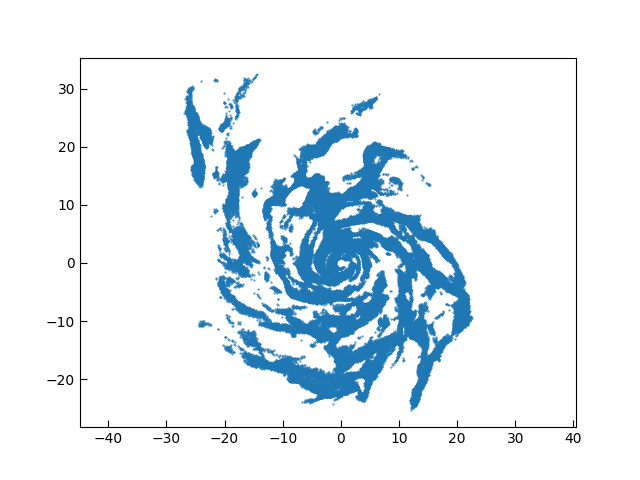

In [5]:
%matplotlib widget

import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficar puntos
plt.scatter(Xs, Ys, s=0.2)

# Ajustar los ejes a la misma escala
plt.axis('equal')

plt.show()


In [6]:
b=0.4 #valor david b=0.4
min_prop  = np.min(prop_final[ np.absolute(Ys) < b])

Xs_band   = Xs[ (np.absolute(Ys) < b) ]
Ys_band   = Ys[ (np.absolute(Ys) < b) ]
prop_band = prop_final[ np.absolute(Ys) < b]-min_prop

In [7]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


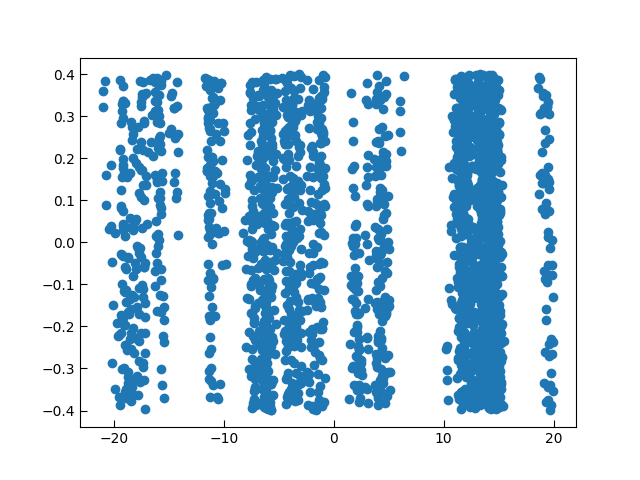

In [8]:
%matplotlib widget
plt.scatter(Xs_band, Ys_band,alpha=1);


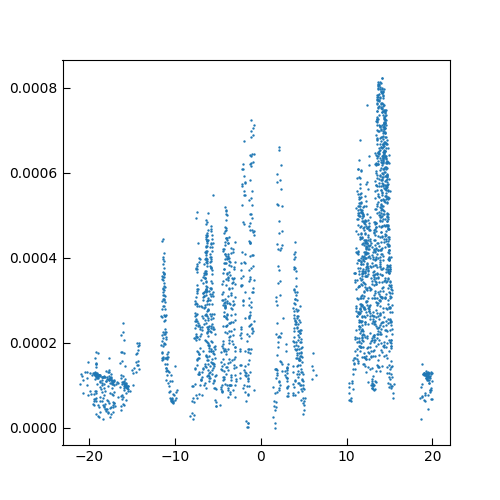

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(Xs_band, prop_band,s=0.5,alpha=1)

#ax.set_xlim()

## Arm Tracing Points Data

In [10]:
samplig_freq=1
df_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

df_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

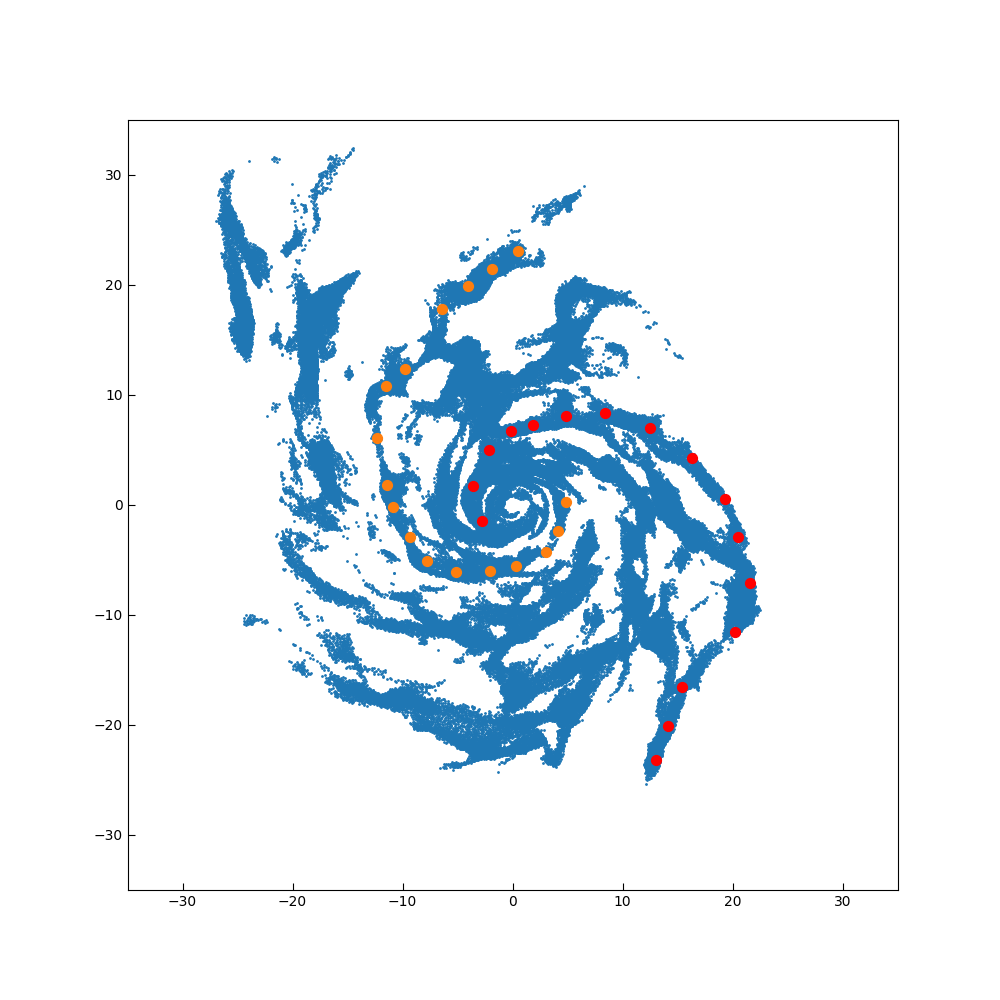

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 50, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 50, color = 'C1')
R = 35
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')

## Rotations

In [13]:
def rotate(x, y, radians):
    x_rot = x * np.cos(radians) + y * np.sin(radians)
    y_rot = -x * np.sin(radians) + y * np.cos(radians)
    return {'x_rot':x_rot,'y_rot':y_rot}

In [14]:
def get_rotations(df_data, x_rot, y_rot):
    Xs = df_data.x
    Ys = df_data.y
    
    if x_rot > 0 and y_rot > 0 :
        a = np.arctan(y_rot/x_rot)
        return rotate(Xs, Ys, a), a

    elif x_rot < 0 and y_rot > 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a    
    
    elif x_rot < 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + np.pi
        return rotate(Xs, Ys, a), a   
    
    elif x_rot > 0 and y_rot < 0:
        a = np.arctan(y_rot/x_rot) + 2*np.pi
        return rotate(Xs, Ys, a), a 

In [15]:
def get_rotated_arm_profile(prop, rotation_coords, b):
    x_rot = rotation_coords['x_rot']
    y_rot = rotation_coords['y_rot']
    
    min_prop  = np.min(prop[ np.absolute(y_rot)<b] )
    x_band = x_rot[ (np.absolute(y_rot)<b) ]
    y_band = prop[ np.absolute(y_rot)<b] - min_prop
    
    return {'x_band':x_band,'y_band':y_band}

In [16]:
b = 0.3

In [17]:
df_arm1['rotation_info'] = df_arm1.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm1['rotation_coords'] = df_arm1.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm1['alpha'] = df_arm1.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm1['All_tracingPoints_rot'] = df_arm1.apply(lambda row: rotate(df_arm1.x, df_arm1.y, row.alpha), axis = 1)
df_arm1['This_tracingPoint_rot'] = df_arm1.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm1['rotated_arm_profile'] = df_arm1.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)


df_arm2['rotation_info'] = df_arm2.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arm2['rotation_coords'] = df_arm2.apply(lambda row: row.rotation_info[0], axis = 1)
df_arm2['alpha'] = df_arm2.apply(lambda row: row.rotation_info[1], axis = 1)
df_arm2['All_tracingPoints_rot'] = df_arm2.apply(lambda row: rotate(df_arm2.x, df_arm2.y, row.alpha), axis = 1)
df_arm2['This_tracingPoint_rot'] = df_arm2.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arm2['rotated_arm_profile'] = df_arm2.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)



df_arms['rotation_info'] = df_arms.apply(lambda row: get_rotations(df, row.x, row.y), axis = 1)
df_arms['rotation_coords'] = df_arms.apply(lambda row: row.rotation_info[0], axis = 1)
df_arms['alpha'] = df_arms.apply(lambda row: row.rotation_info[1], axis = 1)
df_arms['All_tracingPoints_rot'] = df_arms.apply(lambda row: rotate(df_arms.x, df_arms.y, row.alpha), axis = 1)
df_arms['This_tracingPoint_rot'] = df_arms.apply(lambda row: rotate(row.x, row.y, row.alpha), axis = 1)
df_arms['rotated_arm_profile'] = df_arms.apply(lambda row: get_rotated_arm_profile(prop_final, row.rotation_coords, b), axis = 1)

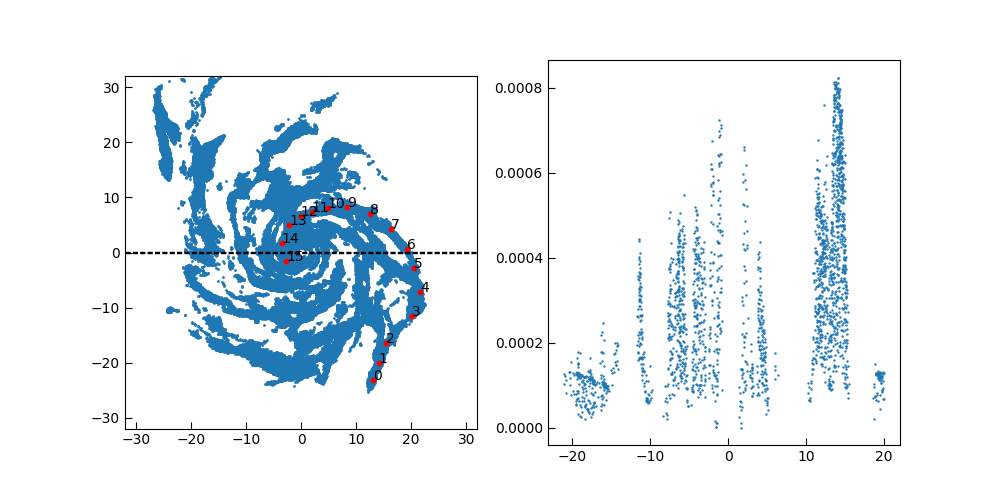

In [19]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 32
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

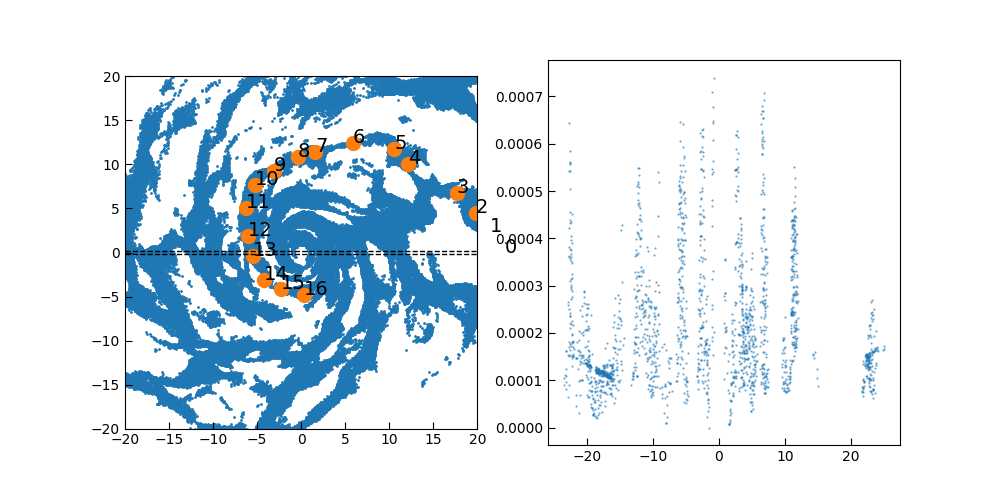

In [20]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
n = 0
ax.scatter(df_arm2.iloc[n].rotation_coords['x_rot'], df_arm2.iloc[n].rotation_coords['y_rot'], s = 1)
ax.scatter(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'], df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], s = 100)

for x, y, id in zip(df_arm2.iloc[n].All_tracingPoints_rot['x_rot'],df_arm2.iloc[n].All_tracingPoints_rot['y_rot'], df_arm2.id):
    ax.text(x, y, str(int(id)), fontsize = 14)

ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(df_arm2.iloc[n].rotated_arm_profile['x_band'], df_arm2.iloc[n].rotated_arm_profile['y_band'], s = 0.5, alpha = 0.5)

ax.set_aspect('equal')

# Fitting Procedure

In [21]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})


In [22]:
#df_params = pd.DataFrame(columns = ['amplitude','stderr_amplitude','center','stderr_center',
                                   # 'sigma','stderr_sigma','gamma','stderr_gamma',
                                   # 'x','y','delta','x_tracing','y_tracing','id_tracing'])

In [23]:
arm = df_arm2.copy(deep=True)

In [24]:
arm

x          y  arm  id  \
0    0.492424  23.071338    2   0   
1   -1.830808  21.455177    2   1   
2   -4.053030  19.940025    2   2   
3   -6.376263  17.818813    2   3   
4   -9.810606  12.364268    2   4   
5  -11.527778  10.849116    2   5   
6  -12.335859   6.101641    2   6   
7  -11.426768   1.859217    2   7   
8  -10.820707  -0.160985    2   8   
9   -9.305556  -2.888258    2   9   
10  -7.790404  -5.110480    2  10   
11  -5.164141  -6.120581    2  11   
12  -2.032828  -6.019571    2  12   
13   0.290404  -5.514520    2  13   
14   3.017677  -4.302399    2  14   
15   4.128788  -2.383207    2  15   
16   4.835859   0.243056    2  16   

                                        rotation_info  \
0   ({'x_rot': [-0.8008076122800384, -0.9292526218...   
1   ({'x_rot': [-0.7934746026212487, -0.9395378380...   
2   ({'x_rot': [-0.7753824106065872, -0.9386688843...   
3   ({'x_rot': [-0.7386581443790092, -0.9202630392...   
4   ({'x_rot': [-0.5997494042376095, -0.8088101150...   
5   ({'x_rot': [-0.5167013772260931, -0.7309298452...   
6   ({'x_rot': [-0.3157941442159427, -0.5266139239...   
7   ({'x_rot': [-0.08563050627403676, -0.274499625...   
8   ({'x_rot': [0.05531626639290545, -0.1125590963...   
9   ({'x_rot': [0.2786305421440904, 0.155563949531...   
10  ({'x_rot': [0.47514641315233674, 0.40557722338...   
11  ({'x_rot': [0.6394860373139906, 0.630913413630...   
12  ({'x_rot': [0.7718992102943463, 0.842708195593...   
13  ({'x_rot': [0.7966728021965873, 0.937522371215...   
14  ({'x_rot': [0.6300754496449701, 0.835762778995...   
15  ({'x_rot': [0.3623579136715163, 0.575507226310...   
16  ({'x_rot': [-0.08352608586179883, 0.0794879194...   

                                      rotation_coords     alpha  \
0   {'x_rot': [-0.8008076122800384, -0.92925262182...  1.549456   
1   {'x_rot': [-0.7934746026212487, -0.93953783800...  1.655922   
2   {'x_rot': [-0.7753824106065872, -0.93866888436...  1.771326   
3   {'x_rot': [-0.7386581443790092, -0.92026303921...  1.914437   
4   {'x_rot': [-0.5997494042376095, -0.80881011503...  2.241539   
5   {'x_rot': [-0.5167013772260931, -0.73092984521...  2.386514   
6   {'x_rot': [-0.3157941442159427, -0.52661392392...  2.682253   
7   {'x_rot': [-0.08563050627403676, -0.2744996258...  2.980299   
8   {'x_rot': [0.05531626639290545, -0.11255909636...  3.156469   
9   {'x_rot': [0.2786305421440904, 0.1555639495314...  3.442545   
10  {'x_rot': [0.47514641315233674, 0.405577223385...  3.722172   
11  {'x_rot': [0.6394860373139906, 0.6309134136304...  4.011544   
12  {'x_rot': [0.7718992102943463, 0.8427081955938...  4.386711   
13  {'x_rot': [0.7966728021965873, 0.9375223712151...  4.765002   
14  {'x_rot': [0.6300754496449701, 0.8357627789953...  5.324050   
15  {'x_rot': [0.3623579136715163, 0.5755072263109...  5.759686   
16  {'x_rot': [-0.08352608586179883, 0.07948791942...  0.050219   

                                All_tracingPoints_rot  \
0   {'x_rot': [23.07659282598064, 21.4112244704358...   
1   {'x_rot': [22.94592996999838, 21.5331481293611...   
2   {'x_rot': [22.51093388178072, 21.3899179327371...   
3   {'x_rot': [21.556547507132468, 20.817613625380...   
4   {'x_rot': [17.76708841643285, 17.9450995294376...   
5   {'x_rot': [15.453258400646023, 16.037446999413...   
6   {'x_rot': [9.7874379274544, 11.153321611129602...   
7   {'x_rot': [3.219115727061239, 5.25264532613291...   
8   {'x_rot': [-0.8355751403783127, 1.511441865001...   
9   {'x_rot': [-7.309323922119735, -4.611431651370...   
10  {'x_rot': [-13.066561608476038, -10.2375241899...   
11  {'x_rot': [-17.95091404775085, -15.21751738302...   
12  {'x_rot': [-22.016120720196344, -19.7415927678...   
13  {'x_rot': [-23.013517398060852, -21.5217682274...   
14  {'x_rot': [-18.605634932195287, -18.6165559674...   
15  {'x_rot': [-11.107197334072913, -12.3113505067...   
16  {'x_rot': [1.6499323130273646, -0.751498757555...   

                                This_tracingPoint_rot  \
0   {'x_rot': 23.0765928259

(-2.5, 2.5)

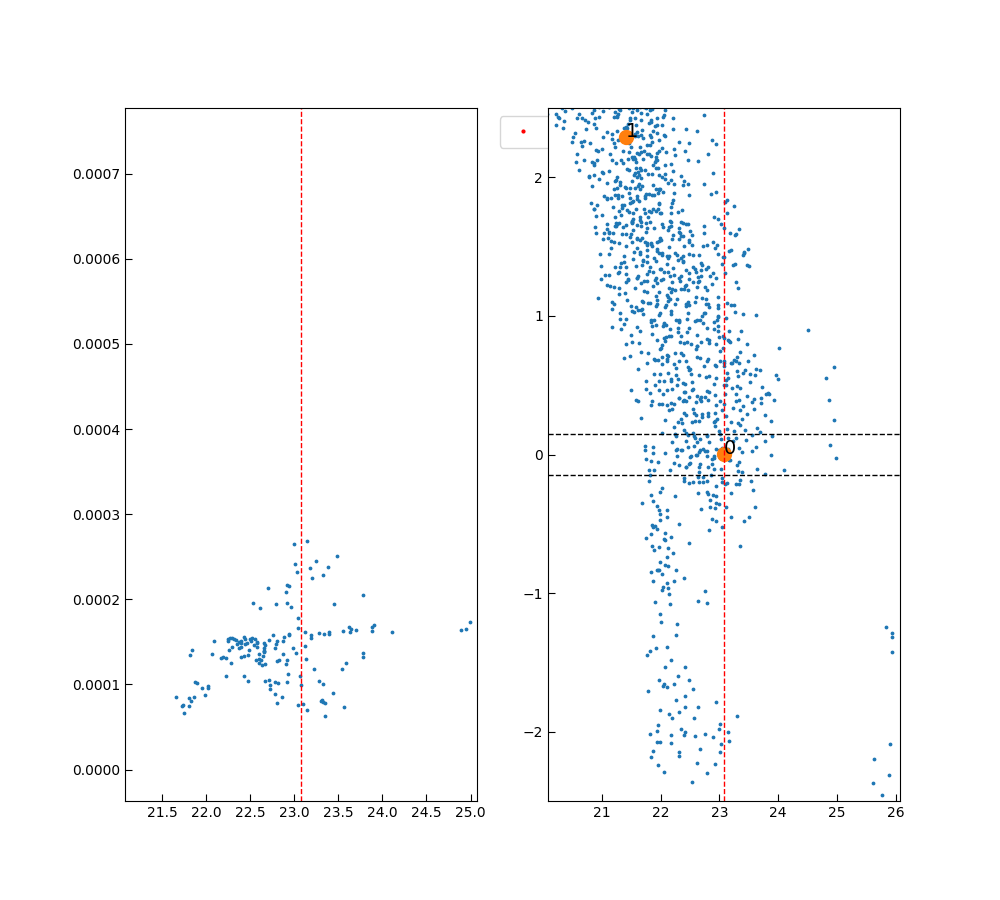

In [208]:
%matplotlib widget

n= 0 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,9), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 14)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

## %run Routines_and_data/gauss_asym.py

In [209]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [210]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


In [211]:
n

0

(1.4353936460006382e-08, 0.0002305975533086736)

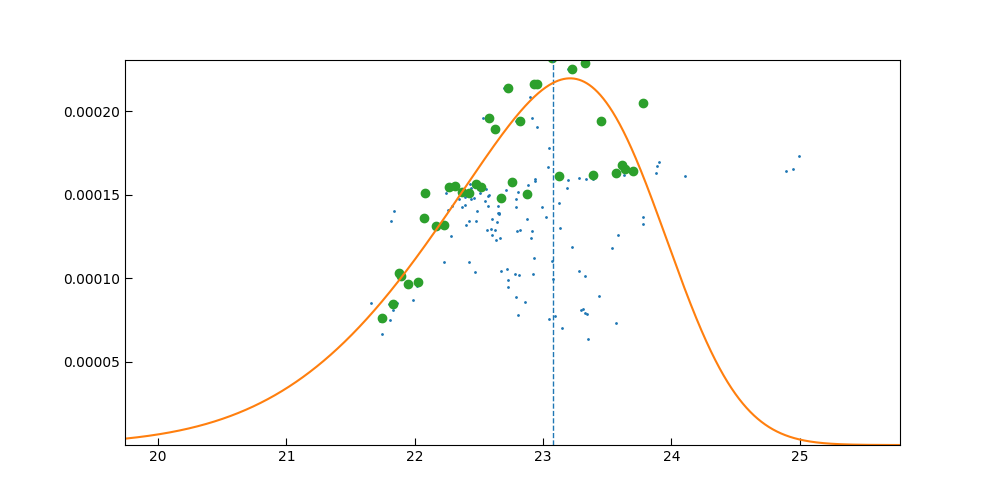

In [212]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [213]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [214]:
df_params

amplitude     center  delta fractured      gamma  id_tracing     sigma  \
0    0.000489   4.115876   0.05     False  -0.151207        16.0  0.740752   
1    0.000190   5.024107   0.05     False  -1.911176        15.0  0.666237   
2    0.000078   5.408162   0.05     False -17.635055        14.0  0.423159   
3    0.000818   4.873196   0.05     False   8.917022        13.0  1.302192   
4    0.001056   6.888066   0.05     False  -6.915761        12.0  1.415410   
5    0.000472   6.673013   0.05     False   4.245391        11.0  1.498085   
6    0.000257  10.484677   0.05     False  -6.186815        10.0  1.063011   
7    0.000181  10.271511   0.05     False -14.077337         9.0  0.723033   
8    0.001061  11.139609   0.05     False   0.007030         7.0  0.767254   
9    0.000524  14.320342   0.05     False  -5.378825         6.0  1.170519   
10   0.000293  16.524848   0.05     False  -7.268003         5.0  1.339788   
11   0.000400  15.083516   0.05     False   6.513510         4.0  0.679791   
12   0.000146  18.882048   0.05     False  -1.802615         3.0  1.253811   
13   0.000719  19.092476   0.05     False   3.479497         2.0  1.091018   
14   0.000364  22.726217   0.05     False  -2.141019         1.0  1.378796   
15   0.000484  23.904023   0.05     False  -2.779156         0.0  1.425183   

    stderr_amplitude  stderr_center  stderr_gamma  stderr_sigma  \
0           0.000381     140.744289    245.423410     18.201171   
1           0.000052       0.312844      4.511365      0.615995   
2           0.000018       0.086543     93.958614      0.088575   
3           0.000072       0.033104      4.047860      0.169425   
4           0.000092       0.046394      2.713614      0.190691   
5           0.000059       0.117492      3.649467      0.321877   
6           0.000042       0.155119      8.154237      0.161161   
7           0.000050       0.017016     10.210262      0.264430   
8           0.000046    2299.043384   3756.038321     23.844612   
9           0.000300       0.182579     12.419409      0.994190   
10          0.000099       0.407426     18.690638      0.417334   
11          0.000022       0.021519      2.185409      0.051384   
12          0.000115       1.474691     10.060291      3.021517   
13          0.000038       0.050487      1.238631      0.102205   
14          0.000024       0.140298      1.402189      0.271540   
15          0.000041       0.092685      1.676786      0.152850   

                                                    x  x_tracing  \
0   [3.7509395685957725, 3.7922595097491856, 3.838...   4.835859   
1   [4.253952972581785, 4.30222901204864, 4.346984...   4.128788   
2   [4.889314229552603, 4.981776230184636, 5.04622...   3.017677   
3   [4.593267712178422, 4.790142004310629, 4.83831...   0.290404   
4   [4.9716484951501405, 5.11933691759926, 5.15591...  -2.032828   
5   [6.590295169761326, 6.63346029952524, 6.728829...  -5.164141   
6   [8.898676336627037, 8.918091248326613, 8.96741...  -7.790404   
7   [9.690637644462386, 9.733397686495094, 9.78399...  -9.305556   
8   [9.86440618819654, 9.905532037809701, 10.01985... -11.426768   
9   [13.436590902523308, 13.485515361756537, 13.53... -12.335859   
10  [15.125818691221603, 15.174011638902268, 15.18... -11.527778   
11  [14.954190536521725, 15.000397774046668, 15.08...  -9.810606   
12  [17.550416567319182, 17.701583239557223, 17.74...  -6.376263   
13  [18.86507578174276, 18.893784865835734, 18.966...  -4.053030   
14  [20.715949497677993, 20.75811083935002, 20.797...  -1.830808   
15  [21.741996588855635, 21.827259143828197, 21.87...   0.492424   

                                                    y  y_tracing  
0   [0.00013112806745042577, 0.0002809857237559295...   0.243056  
1   [0.00012288396753199843, 0.0001384729928834856...  -2.383207  
2   [8.471789516959283e-05, 0.00010276871641970629...  -4.302399  
3   [0.00012579670688269706, 0.0002908197676085533...  -5.514520  
4   [4.1978405102649014e-05, 0.00014433526700

In [215]:
df_copy = df_params.copy()
#df_params.drop([26], inplace = True)

In [216]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.05):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.05):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



In [217]:
arm.iloc[n].id

0

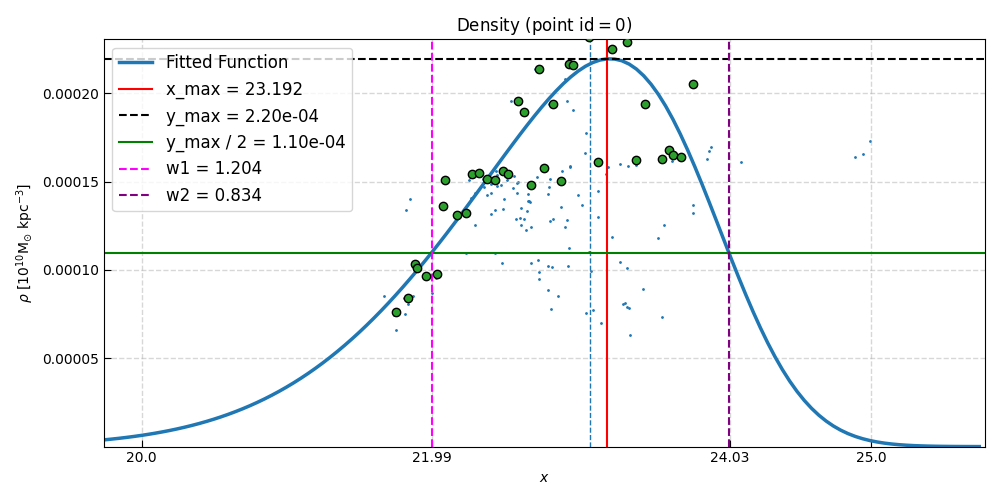

In [219]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

#ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')


ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm2_halo{id_halo}_.png',dpi=200)

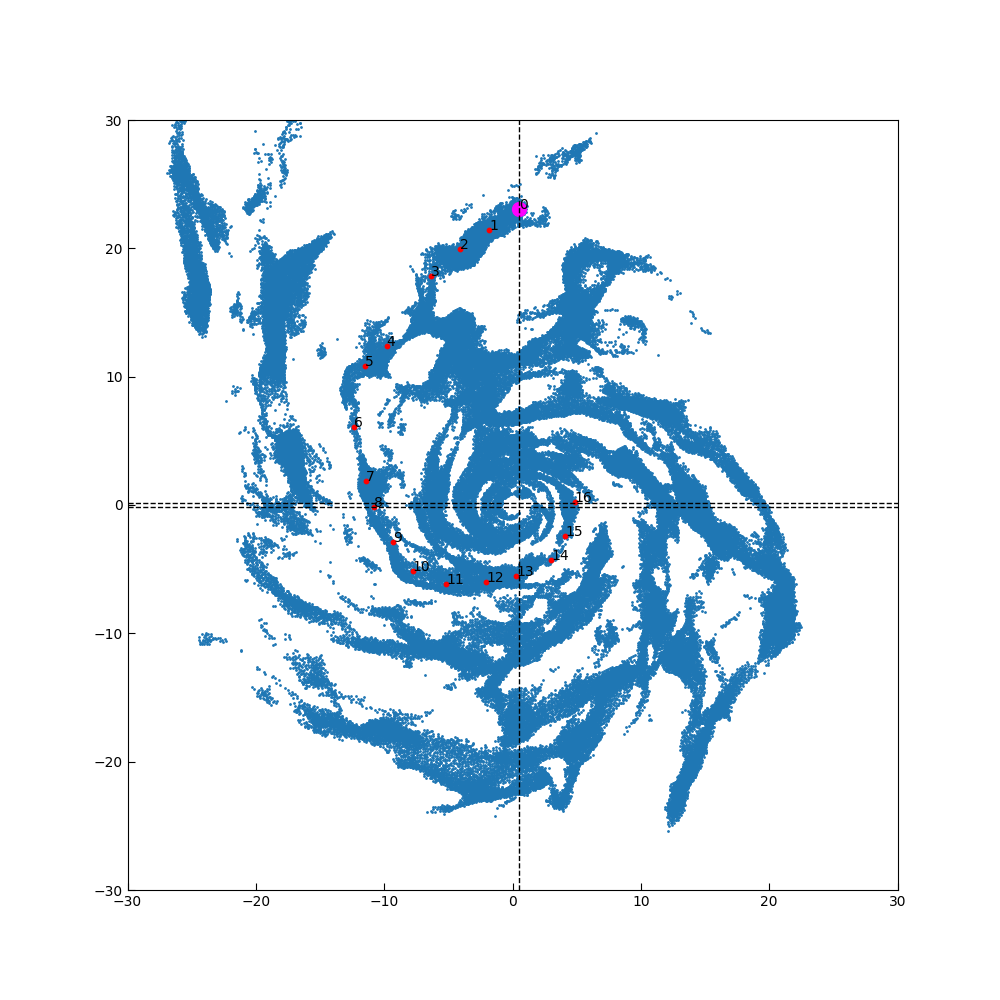

In [221]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm2.x, df_arm2.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm2.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 30
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [222]:
df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_adicionales_HALO{id_halo}.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm2_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm2_all_points_HALO{id_halo}_partial.csv')

In [223]:
df_params.to_csv('df_params_rho_arm2_adicionales_dani.csv')

## arm 1

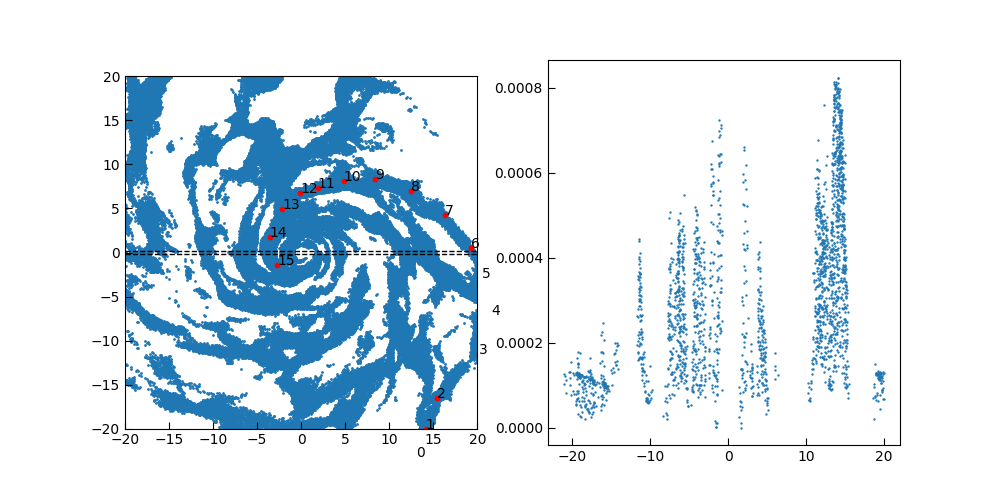

In [224]:
fig, (ax,ax2) = plt.subplots(figsize=(10,5), ncols = 2)
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 20
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax2.scatter(Xs_band,prop_band,s=0.5,alpha=1)

ax.set_aspect('equal')

In [225]:
df_params = pd.DataFrame({
    'amplitude': [],
    'stderr_amplitude': [],
    'center': [],
    'stderr_center': [],
    'sigma': [],
    'stderr_sigma': [],
    'gamma': [],
    'stderr_gamma': [],
    'x': [],
    'y': [],
    'delta': [],
    'x_tracing': [],
    'y_tracing': [],
    'id_tracing': []
})

arm = df_arm1.copy(deep=True)

In [226]:
arm

x          y  arm  id  \
0   13.017677 -23.191288    1   0   
1   14.128788 -20.059975    1   1   
2   15.441919 -16.524621    1   2   
3   20.189394 -11.575126    1   3   
4   21.603535  -7.130682    1   4   
5   20.492424  -2.888258    1   5   
6   19.280303   0.546086    1   6   
7   16.351010   4.283460    1   7   
8   12.512626   7.010732    1   8   
9    8.371212   8.323864    1   9   
10   4.835859   8.121843    1  10   
11   1.906566   7.313763    1  11   
12  -0.113636   6.707702    1  12   
13  -2.133838   4.990530    1  13   
14  -3.547980   1.758207    1  14   
15  -2.739899  -1.474116    1  15   

                                        rotation_info  \
0   ({'x_rot': [0.6764149359503523, 0.874750250962...   
1   ({'x_rot': [0.6291024285191703, 0.834913462101...   
2   ({'x_rot': [0.554910845912076, 0.7674018668904...   
3   ({'x_rot': [0.36026768506427675, 0.57332988474...   
4   ({'x_rot': [0.20953833620897078, 0.41224316939...   
5   ({'x_rot': [0.06866495773081624, 0.25529808764...   
6   ({'x_rot': [-0.06605357358247069, 0.0999975592...   
7   ({'x_rot': [-0.24475226933365687, -0.113914125...   
8   ({'x_rot': [-0.4289481040518907, -0.3453333874...   
9   ({'x_rot': [-0.5949125875709781, -0.5676070854...   
10  ({'x_rot': [-0.7096487443824353, -0.7362530604...   
11  ({'x_rot': [-0.7851431506176548, -0.8701236061...   
12  ({'x_rot': [-0.7992130118555019, -0.9341709239...   
13  ({'x_rot': [-0.7185684228715787, -0.9068105048...   
14  ({'x_rot': [-0.3163412342183937, -0.5271929807...   
15  ({'x_rot': [0.4173044611782168, 0.330309102790...   

                                      rotation_coords     alpha  \
0   {'x_rot': [0.6764149359503523, 0.8747502509622...  5.223880   
1   {'x_rot': [0.6291024285191703, 0.8349134621018...  5.326013   
2   {'x_rot': [0.554910845912076, 0.76740186689048...  5.463930   
3   {'x_rot': [0.36026768506427675, 0.573329884742...  5.762609   
4   {'x_rot': [0.20953833620897078, 0.412243169398...  5.964375   
5   {'x_rot': [0.06866495773081624, 0.255298087640...  6.143165   
6   {'x_rot': [-0.06605357358247069, 0.09999755925...  0.028316   
7   {'x_rot': [-0.24475226933365687, -0.1139141255...  0.256212   
8   {'x_rot': [-0.4289481040518907, -0.34533338748...  0.510711   
9   {'x_rot': [-0.5949125875709781, -0.56760708545...  0.782562   
10  {'x_rot': [-0.7096487443824353, -0.73625306045...  1.033756   
11  {'x_rot': [-0.7851431506176548, -0.87012360615...  1.315790   
12  {'x_rot': [-0.7992130118555019, -0.93417092391...  1.587736   
13  {'x_rot': [-0.7185684228715787, -0.90681050481...  1.974848   
14  {'x_rot': [-0.3163412342183937, -0.52719298072...  2.681510   
15  {'x_rot': [0.4173044611782168, 0.3303091027908...  3.635190   

                                All_tracingPoints_rot  \
0   {'x_rot': [26.59503227868928, 24.4083419840475...   
1   {'x_rot': [26.456442987568323, 24.536202513696...   
2   {'x_rot': [25.832445568090108, 24.303219532755...   
3   {'x_rot': [22.82814462372005, 22.2346173068063...   
4   {'x_rot': [19.630720375725012, 19.704370293789...   
5   {'x_rot': [16.126927694428648, 16.790148090748...   
6   {'x_rot': [12.355863015806971, 13.555182942666...   
7   {'x_rot': [6.71565872684085, 8.584029798269444...   
8   {'x_rot': [0.02073601081313292, 2.520644854384...   
9   {'x_rot': [-7.121187027685492, -4.125403454033...   
10  {'x_rot': [-13.266785091749764, -10.0078385949...   
11  {'x_rot': [-19.15758545567136, -15.84725408619...   
12  {'x_rot': [-23.408463724090392, -20.2964206737...   
13  {'x_rot': [-26.441684827657223, -23.9993488665...   
14  {'x_rot': [-21.961488601187902, -21.5666895726...   
15  {'x_rot': [-0.47583857004365093, -2.9379283962...   

                                This_tracingPoint_rot  \
0   {'x_rot': 26.59503227868928, 'y_rot': 1.421085...   
1   {'x_rot': 24.536202513696118, 'y_rot': -1.7763...   
2   {'x_rot': 22.616718916187832, 'y_rot': 3.55271...   
3   {'x_rot': 23.272197481883328, 'y_rot': 3.55271...   
4   {'x_rot': 22.

(-2.5, 2.5)

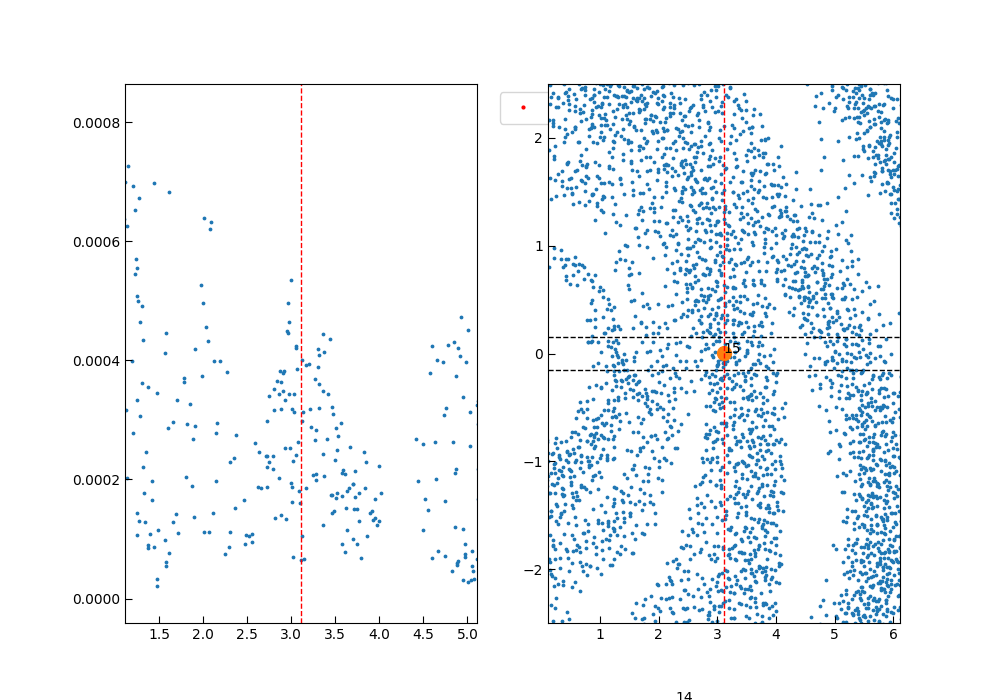

In [358]:
n= 15 #n = 86
fig, (ax,ax2) = plt.subplots(figsize=(10,7), ncols = 2)

x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
y_tracing = arm.iloc[n].This_tracingPoint_rot['y_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 3, alpha = 1)
#ax.set_xlim(0,np.max(x_band)+1)
ax.set_xlim(x_tracing-2,x_tracing+2)
klicker = clicker(ax, ["limits"], markers=["o"], colors = ['red'], markersize = 2)
x_tracing_all = arm.iloc[n].All_tracingPoints_rot['x_rot']
y_tracing_all = arm.iloc[n].All_tracingPoints_rot['y_rot']
x_coords = arm.iloc[n].rotation_coords['x_rot']
y_coords = arm.iloc[n].rotation_coords['y_rot']
ax2.scatter(x_coords, y_coords, s = 3)
ax2.scatter(x_tracing_all, y_tracing_all, s = 100)
for x, y, id in zip(x_tracing_all,y_tracing_all, arm.id):
    ax2.text(x, y, str(int(id)), fontsize = 10)
   
ax2.axvline(x = x_tracing, lw = 1, ls = '--', color = 'red')
ax2.axhline(y=b/2,ls='--',lw=1,color='black')
ax2.axhline(y=-b/2,ls='--',lw=1,color='black')
R = 20
ax2.set_xlim(x_tracing-3,x_tracing+3)
ax2.set_ylim(-2.5,2.5)

In [359]:
dict_lims = klicker.get_positions()
#print(dict_lims)

In [360]:
delta = 0.05
model = get_asym_gaussian_fit(dict_lims,arm,n,delta)

/home/daniel/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


(3.5977293129378534e-11, 0.0004353558275843441)

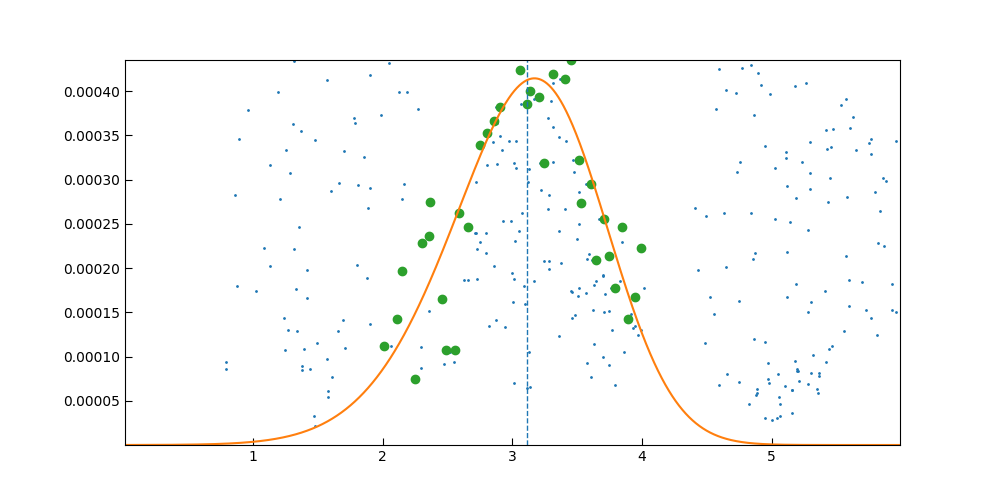

In [361]:
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1, marker = 'o')

fitted_model = eval_fitted_model(model)
ax.plot(fitted_model['x_eval'], fitted_model['y_eval'], color = 'C1')
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o')

ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

In [362]:
fractured = False

df_params = add_row_with_param_info(model, df_params, arm.iloc[n], delta, fractured)

In [363]:
df_params

amplitude     center  delta fractured      gamma  id_tracing     sigma  \
0    0.001287  26.927486   0.05     False  -2.990199         0.0  1.243473   
1    0.001065  23.968861   0.05     False   1.423619         1.0  1.136209   
2    0.000338  22.544945   0.05     False  -0.003343         2.0  0.564862   
3    0.000118  23.440874   0.05     False -57.417446         3.0  0.575267   
4    0.000868  22.245119   0.05     False   0.006656         4.0  0.678157   
5    0.000353  21.262837   0.05     False  -1.703852         5.0  1.221203   
6    0.000273  18.420844   0.05     False   1.528772         6.0  0.823692   
7    0.000285  15.344549   0.05     False   8.134163         7.0  1.314633   
8    0.001047  14.434576   0.05     False  -0.655365         8.0  0.580693   
9    0.000689  12.238265   0.05     False  -2.072207         9.0  0.931161   
10   0.000919   9.782579   0.05     False   0.009102        10.0  1.379973   
11   0.000718   7.874038   0.05     False  -3.853234        11.0  1.617382   
12   0.000562   6.266197   0.05     False   9.970505        12.0  0.695581   
13   0.000656   3.784282   0.05     False   8.477069        13.0  1.222137   
14   0.000738   3.748053   0.05     False  -0.203983        14.0  0.749416   
15   0.000617   3.614213   0.05     False  -1.533165        15.0  0.817256   

    stderr_amplitude  stderr_center   stderr_gamma  stderr_sigma  \
0           0.000059       0.051500       0.835822      0.127433   
1           0.000189       0.445310       1.917415      0.664752   
2           0.000029  133124.546451  295378.840754    283.469541   
3           0.000010       0.003774      56.185424      0.068829   
4           0.000028   88830.924664  164171.355316    130.541439   
5           0.000028       0.240117       1.630667      0.412380   
6           0.000031       0.288170       1.969415      0.395959   
7           0.000034       0.058036       5.249601      0.226654   
8           0.000040       0.382571       1.233593      0.190671   
9           0.000023       0.055260       0.526489      0.075245   
10          0.000326  101702.833192   92374.984594    512.222865   
11          0.000831       0.288138       8.784450      2.610072   
12          0.000048       0.020963       6.222107      0.087397   
13          0.000037       0.037291       4.505490      0.093103   
14          0.000080      25.851014      45.279089      4.139826   
15          0.000031       0.141018       0.964597      0.160888   

                                                    x  x_tracing  \
0   [25.050783990236912, 25.13093709623488, 25.220...  13.017677   
1   [23.08401933432769, 23.251516656614513, 23.294...  14.128788   
2   [21.92122917039522, 21.95699075155281, 22.0383...  15.441919   
3   [22.730653023959384, 22.803851320794397, 22.87...  20.189394   
4   [20.959224712971064, 21.05346322050137, 21.075...  21.603535   
5   [19.726824620878816, 19.87667315127954, 19.924...  20.492424   
6   [18.061739302778474, 18.123285468189295, 18.19...  19.280303   
7   [15.24112311393347, 15.37037348846755, 15.4210...  16.351010   
8   [12.988288859095775, 13.049995030659865, 13.09...  12.512626   
9   [10.211519285597436, 10.296108219060812, 10.33...   8.371212   
10  [8.006142651681953, 8.12230930070503, 8.170363...   4.835859   
11  [6.853684331104803, 6.892699978243133, 6.95391...   1.906566   
12  [5.938304353022415, 6.044367223411429, 6.22685...  -0.113636   
13  [3.754123746408547, 3.7871785164138148, 3.8503...  -2.133838   
14  [2.8729994370721124, 2.913381642976396, 2.9290...  -3.547980   
15  [2.011426245048738, 2.111185237710431, 2.15014...  -2.739899   

                                                    y  y_tracing  
0   [0.0003306442287852033, 0.00020832003768523475... -23.191288  
1   [0.00011778366954787138, 0.0001906064052049310... -20.059975  
2   [0.00015224203492616339, 0.0001484235007773839... -16.524621  
3   [7.641489571639734e-05, 8.196636627776462e-05,... -11.575126  
4   [5.854455918432092e-05, 

In [364]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
params

amplitude                                                 0.000617165
center                                                        3.61421
delta                                                            0.05
fractured                                                       False
gamma                                                        -1.53317
id_tracing                                                         15
sigma                                                        0.817256
stderr_amplitude                                          3.12084e-05
stderr_center                                                0.141018
stderr_gamma                                                 0.964597
stderr_sigma                                                 0.160888
x                   [2.011426245048738, 2.111185237710431, 2.15014...
x_tracing                                                     -2.7399
y                   [0.00011153591481087189, 0.0001428749099532286...
y_tracing           

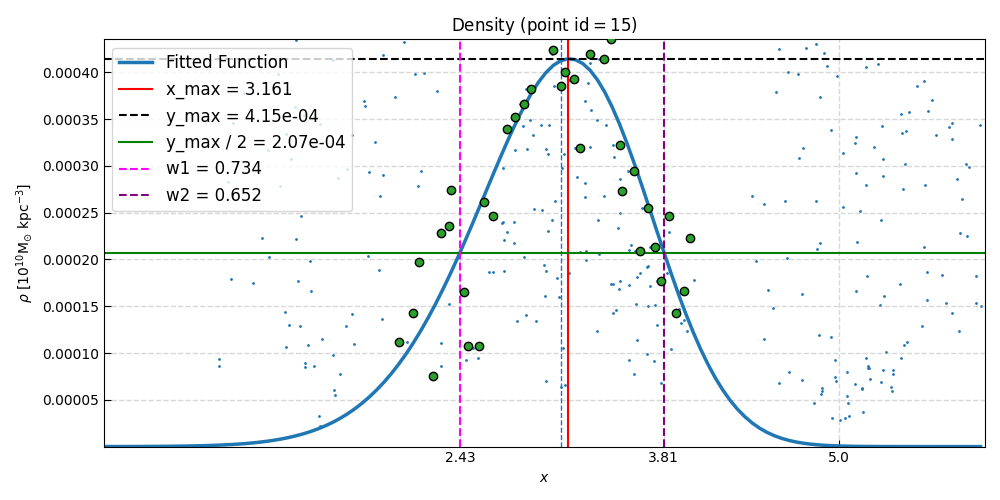

In [365]:
n_actual = df_params.iloc[-1].name
params = df_params.iloc[n_actual]
fig, ax = plt.subplots(figsize=(10,5))
x_tracing = arm.iloc[n].This_tracingPoint_rot['x_rot']
ax.axvline(x = x_tracing, lw = 1, ls = '--')

x_band = arm.iloc[n].rotated_arm_profile['x_band']
y_band = arm.iloc[n].rotated_arm_profile['y_band']
ax.scatter(x_band, y_band, s = 1, alpha = 1)

fitted_model = eval_fitted_model(model)
ax.scatter(model['x_max'], model['y_max'], color = 'C2', marker = 'o',  linewidths = 1, edgecolors = 'k', zorder = 10)

ax.set_xlim(0,np.max(x_band)+1)
plot_fit_and_widths_dani(params, ax)
ax.set_xlim(np.min(fitted_model['x_eval']), np.max(fitted_model['x_eval']))
ax.set_ylim(np.min(fitted_model['y_eval']), np.max(fitted_model['y_eval'])+0.05*np.max(fitted_model['y_eval']))

ax.set_xlabel(r'$x$')
rho_units      = r"$ \rho \ [10^{10} \mathrm{M}_{\odot} \ \mathrm{kpc}^{-3}] $"
ax.set_ylabel(rho_units)
ax.set_title(r'$\mathrm{{Density}} \ (\mathrm{{point \ id}}={{{0}}})$'.format(arm.iloc[n].id))
fig.tight_layout()
fig.savefig(f'FIT_PLOTS/rho_point_id_{n}_arm1_HALO{id_halo}_.png',dpi=200)

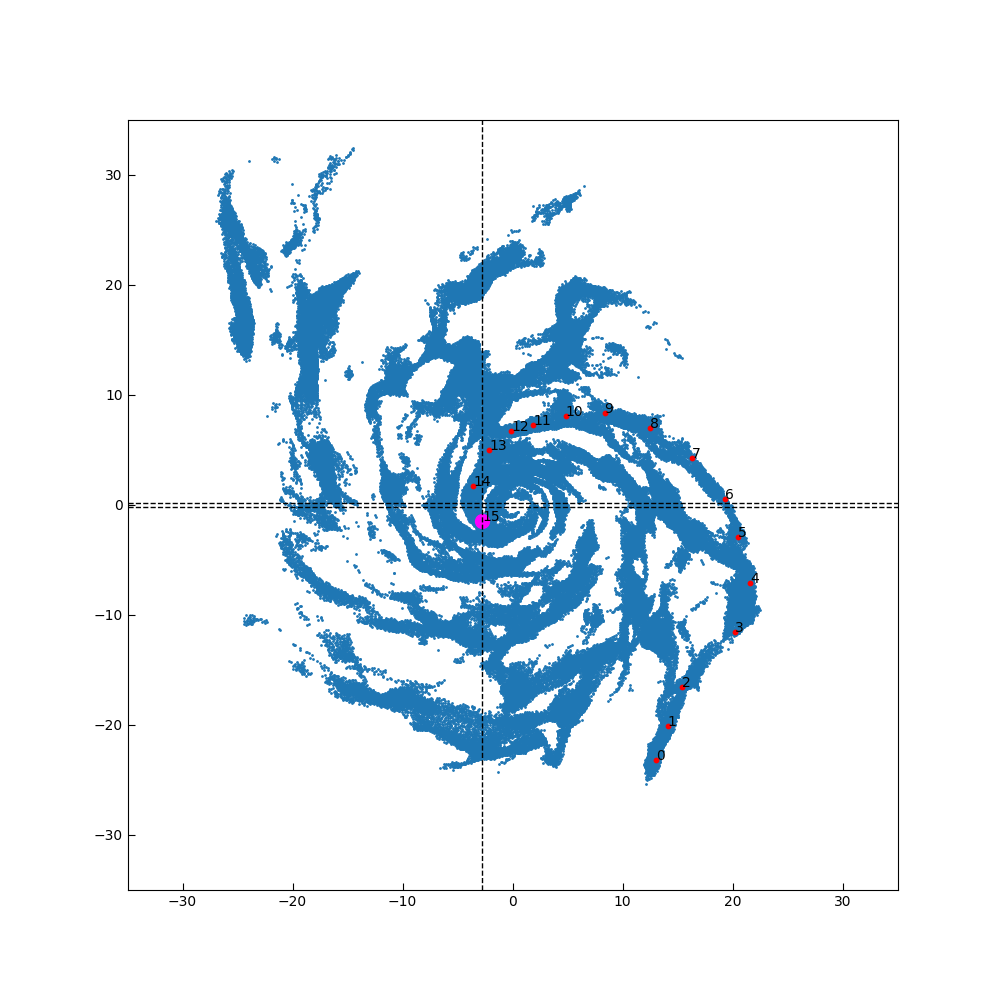

In [366]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(df.x, df.y, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 10, color = 'red')
ax.scatter(df_params.iloc[n_actual].x_tracing,df_params.iloc[n_actual].y_tracing,color='magenta',s = 100)
ax.axvline(x=df_params.iloc[n_actual].x_tracing,ls='--',lw=1,color='black')

for i, row in df_arm1.iterrows():
    ax.text(row.x, row.y, str(int(row.id)))
R = 35
ax.axhline(y=b/2,ls='--',lw=1,color='black')
ax.axhline(y=-b/2,ls='--',lw=1,color='black')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

ax.set_aspect('equal')

In [367]:
#df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_adicionales_HALO{id_halo}_.csv', index = False)

df_params.to_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv', index = False)

df_params.to_csv('df_params_rho_arm1_all_points_HALO{id_halo}_.csv')